# Preliminaries

In [1]:
import sys ; sys.path.append('..')
import rrtd
from experiment import generate
import analysis
from tqdm.auto import tqdm
import numpy as np
import automated_design
import run_models

%load_ext autoreload
%autoreload 2

tomov_interop could not load matlab


R[write to console]: Loading required package: dfidx

R[write to console]: 
Attaching package: ‘dfidx’


R[write to console]: The following object is masked from ‘package:stats’:

    filter




In [2]:
exp = analysis.load_exp1()

Modal sequence length=99 ['CircleGraphNavigationInstruction', 'SimpleInstruction', 'HTMLForm', 'CircleGraphNavigationx2', 'MapInstruction', 'CircleGraphNavigationx2', 'SimpleInstruction', 'CircleGraphNavigationx60', 'HTMLForm', 'CirclePathIdentificationx2', 'SimpleInstruction', 'CirclePathIdentificationx10', 'HTMLForm', 'CirclePathIdentificationx2', 'SimpleInstruction', 'CirclePathIdentificationx11', 'survey-multi-choice']
summary of participant data. total participants 966
	type complete | # participants 952
	type did-at-most-12-things-then-restart | # participants 5
	type instructions-twice | # participants 1
	type unusable: completed after restart | # participants 8
Modal sequence length=99 ['CircleGraphNavigationInstruction', 'SimpleInstruction', 'HTMLForm', 'CircleGraphNavigationx2', 'MapInstruction', 'CircleGraphNavigationx2', 'SimpleInstruction', 'CircleGraphNavigationx60', 'HTMLForm', 'CirclePathIdentificationx2', 'SimpleInstruction', 'CirclePathIdentificationx10', 'HTMLForm', 

In [3]:
graph_list = [
    rrtd.Graph(dict(ginfo['adjacency']))
    for ginfo in exp.trials['graph']
]
nstates = len(graph_list[0].state_list)
assert all(len(g.state_list) == nstates for g in graph_list)

In [4]:
responses_by_graph = np.zeros((len(graph_list), nstates))
responses_by_copy_by_graph = {ptype.key: np.zeros(responses_by_graph.shape) for ptype in analysis.probes}
responses_by_g6 = {automated_design.dump_g6(g): np.zeros(nstates) for g in graph_list}
responses_by_copy_by_g6 = {ptype.key: {automated_design.dump_g6(g): np.zeros(nstates) for g in graph_list} for ptype in analysis.probes}

tot = 0
for p in exp.participants:
    gi = p.config_idx()['graph']
    g6 = automated_design.dump_g6(graph_list[gi])

    for task, row in p.probe_trials():
        for r in [
            responses_by_copy_by_graph[row.data['copy']][gi],
            responses_by_graph[gi],
            responses_by_copy_by_g6[row.data['copy']][g6],
            responses_by_g6[g6],
        ]:
            r[row.data['states'][0]] += 1

assert np.allclose(
    sum(responses_by_copy_by_graph[ptype.key].sum() for ptype in analysis.probes),
    responses_by_graph.sum())


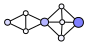

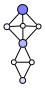

In [5]:
def plot(g, z, *, horizontal=True, plot_graph_kwargs={}):
    #coord = generate.graphviz_coordinates(g, layout='neato')
    kw = dict(
        graph_arg=dict(mode='sgd'),
        # Don't seem to need this with model=sgd
        #state_list=np.argsort(run_models.log_betweenness_centrality(g)['scores']).tolist(),
        **plot_graph_kwargs,
    )
    coord = generate.graphviz_coordinates(g, layout='neato', plot_graph_kwargs=kw)
    return rrtd.plot_graph(
        g,
        z=z,
        pos=generate.normalized_xy_coords(generate.svd_coordinates(coord), horizontal=horizontal),
        node_scaling=(0.07,0.07),
        graph_arg=dict(splines='true'),
        **plot_graph_kwargs,
        #node_arg=dict(penwidth="0.6"),
        #edge_arg=dict(penwidth='0.6'),
    )
from IPython.display import display
display(plot(graph_list[-4], responses_by_graph[1]))
display(plot(graph_list[-4], responses_by_graph[1], horizontal=False))

In [6]:
# We wrap probe here as though it were a model to simplify below code.
class WrappedProbe(object):
    def __init__(self, probe):
        self.key = probe.key
        self.verbose = probe.verbose
        self.name = probe.name
    def model(self, mdp):
        g6 = automated_design.dump_g6(mdp)
        if self.key == 'all-behavior':
            r = responses_by_g6[g6]
        else:
            r = responses_by_copy_by_g6[self.key][g6]
        return dict(scores=r)

wrapped_probes = [WrappedProbe(pt) for pt in analysis.probes] + [WrappedProbe(analysis.ProbeType('all-behavior', None, 'All Behavior', None))]

# Plot all graphs

In [7]:
f = rrtd.display_graphs([
    plot(g, None)
    for gi, g in enumerate(graph_list)], columns=5, html=False, cellheight=80, cellwidth=90, cellpadding=10, should_display=False)
analysis.savesvg('graphs.svg', f)
f

# Appendix: Show full behavioral dataset

In [8]:
def show(config, gs, *, columns=3, should_display=False):
    return rrtd.display_graphs([
        plot(g, config.model(g)['scores'], horizontal=True)
        for g in gs], columns=columns, html=False, cellheight=80, cellwidth=90, cellpadding=10, should_display=should_display)

for ptype in wrapped_probes:
    print(ptype.name)
    cols = 5
    show(ptype, graph_list, should_display=True, columns=cols)
    analysis.savesvg(f'graph-heatmap-{ptype.key}-full.svg', show(ptype, graph_list, columns=cols))

Explicit Probe


Implicit Probe


Teleportation Question


All Behavior


# Showing small # of examples.

In [9]:
import prior_envs

def graph_examples(ms, gs, tag=''):
    for m in ms:
        g = show(m, gs, columns=1)
        '''
        rrtd.display_graphs([
            plot(g, m.model(g)['scores'], horizontal=True)
            #, plot_graph_kwargs=dict(title=m.name))
            for g in gs
        ], columns=1, html=False, cellheight=80, cellwidth=90, cellpadding=10, should_display=False)
        '''
        analysis.savesvg(f'graph-examples-{tag}-{m.key}.svg', g)

# For "Comparing accounts..." figure
graph_examples(
    analysis.models_without_random_or_fixed,
    [
        prior_envs.f2c,
        graph_list[-4],
        graph_list[9],
    ],
    tag='small',
)

# For "Experimental results..." figure
graphs_for_medium = [
    graph_list[-4],
    graph_list[9],
    graph_list[7],
    graph_list[18],
]
graph_examples(
    list(analysis.models_without_random_or_fixed) + wrapped_probes,
    graphs_for_medium,
    tag='medium',
)

/Users/carlos/pu/tmp/rrtd/rrtd/journal/../plotting.py:129: UserWarning: Ignoring data because data range 0.0 is smaller than eps=1e-05
  warnings.warn(f'Ignoring data because data range {diff} is smaller than eps={eps}')


In [10]:
# Logging number of participants per graph for Figure 5a caption.
# Need to look at 'Teleportation Question', since it has 1 question/participant.
# Others will be larger; probes have 10 questions/parti, "all behavior" has 21/parti.
for probe in wrapped_probes:
    print(probe.name, [
        probe.model(g)['scores'].sum()
        for g in graphs_for_medium
    ])

Explicit Probe [280.0, 260.0, 250.0, 260.0]
Implicit Probe [280.0, 260.0, 250.0, 260.0]
Teleportation Question [28.0, 26.0, 25.0, 26.0]
All Behavior [588.0, 546.0, 525.0, 546.0]
